# Homework 4 (Convalutional Neural Network)
* 截止日期：2021/12/29 18:00前（當天上課前）
* 繳交格式：  
        | --HW4_學號_姓名.zip  
            |-- Hw4_學號_姓名.ipynb
* 繳交檔案時請將debug、紀錄或測試用的檔案刪除(如：.ipynb_checkpoints)
* 請將輸出結果儲存，以便作業檢查
* 若有參考書面或網路資訊，請附上書名或連結，沒付上參考資料者視同剽竊，本作業以0分記
* 請使用`markdown`區塊描述作法或填寫問題

## Homework 4 : CNN with Keras
 作業說明：
 >作業4使用[Kaggle Dogs vs. Cats ](https://www.kaggle.com/c/dogs-vs-cats/overview) 所提供的資料集，本次作業中只會用到train.zip，裡面存有總共25000張貓狗的照片，運用這些照片進行CNN貓狗分類器。

### Part 0 讀取檔案與前處理
已經幫各位寫好解壓縮的方法了~ 請直接執行已寫好的部分，並完成下列要求<br>
**執行以下程式前，請先將train.zip上傳**

* 請使用**ImageDataGenerator**讀取資料
* 利用**ImageDataGenerator**進行資料擴充
* 請將validtion資料當成test資料

[可以做哪些資料擴充，請參考此網址](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

In [1]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
# from google drive import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
PATH_FILE = "/content/drive/MyDrive/機器深度學習導論/hw4/" #根據存放train.zip的位置改變

In [4]:
zf = zipfile.ZipFile(PATH_FILE + "train.zip", 'r') #讀取壓縮檔
zf.extractall() #解壓縮檔

In [5]:
#根據檔案的類別建立子目錄
# PATH 放入解好壓縮的train資料夾
def build_subdir(PATH):
    for file_name in os.listdir(PATH):
        category = file_name.split('.')[0]
        sub_path = PATH + '/' + category
        if not os.path.isdir(sub_path):
            os.mkdir(sub_path)
        shutil.move(PATH+'/'+file_name,sub_path)

In [6]:
PATH = "/content/train"

In [7]:
build_subdir('/content/train')

In [8]:
#利用ImageDataGenerator讀取資料
datagen = ImageDataGenerator()
datasets = datagen.flow_from_directory(
    PATH, 
    class_mode="categorical", 
    color_mode = "rgb", 
    batch_size=64, 
    target_size = (256,256))

Found 25000 images belonging to 2 classes.


In [9]:
train_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.33,
    rotation_range=40, 
    width_shift_range=0.1, 
    height_shift_range=0.1, 
    zoom_range=0.2)

test_datagen = ImageDataGenerator(
    rescale=1./255, 
    validation_split=0.33)

In [10]:
train_datasets = train_datagen.flow_from_directory(
    PATH, 
    class_mode="categorical", 
    color_mode = "rgb", 
    batch_size=64, 
    target_size = (256,256), 
    classes=['cat', 'dog'], 
    subset='training')

Found 16750 images belonging to 2 classes.


In [11]:
test_datasets = test_datagen.flow_from_directory(
    PATH, 
    class_mode="categorical", 
    color_mode = "rgb", 
    batch_size=64, 
    target_size = (256,256), 
    classes=['cat', 'dog'], 
    subset='validation')

Found 8250 images belonging to 2 classes.


In [12]:
#供大家檢查是否有成功讀入
#若成功的話會隨機其中一個類別中輸出圖片
def check(train_datasets):
    x,y = train_datasets.next()
    index = random.randint(1,x.shape[0])
    plt.imshow(x[index,:,:,:].astype('int32'))
    plt.show()
    print("label:\t{}".format(y[index,:]))

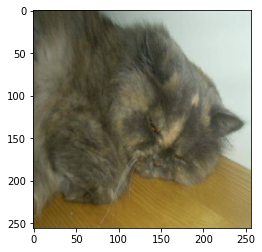

label:	[1. 0.]


In [13]:
# 請利用check 檢查是否有成功讀取 有輸出圖與label就成功
check(datasets)

In [14]:
def save_train_history(train_history, train, file_name):
    '''save training history as png file if re-fit a new model'''
    plt.plot(train_history.history[train])
    plt.title('Train History')
    plt.ylabel(train)
    plt.xlabel('Epoch')
    plt.legend(['train'], loc='center right')
    return plt.savefig(PATH_FILE + f'{file_name}.png')

In [15]:
def show_train_history(file_name):
    '''show saved training history png file'''
    import matplotlib.image as mpimg
    img = mpimg.imread(PATH_FILE + f'{file_name}.png')
    imgplot = plt.imshow(img)
    plt.show()

### Part1 模型建構、執行與結果呈現

請在此區塊後使用**一個或多個區塊**進行CNN模型訓練，**需要**包含以下內容：

- **CNN模型 1**
    - 自行設定模型**超參數**
    - 利用`summary()`顯示模型架構
- **CNN模型 2**
    - 利用keras內建的CNN model
    - 利用`summary()`顯示模型架構
<br><br>**以下模型1、2都要**<br><br>
- 計算**準確度（Accuracy）**
    - 使用**訓練**資料進行訓練並輸出**準確度**
- 將**訓練過程**利用畫圖套件視覺化
    - 使用**訓練**資料進行訓練的**準確度**變化繪製準確度變化圖
    - 使用**訓練**資料進行訓練的**Loss**變化繪製損失率變化圖
- 檢驗訓練結果
    - 評估**測試**資料

In [16]:
# import 套件
from keras.models import Sequential, load_model
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.callbacks import EarlyStopping

#### CNN model 1

In [17]:
# initialize the state to load or not to load the saved model
LOAD_MODEL = True

In [18]:
#建立一個model
model = Sequential()
#在model中增加卷積層 
model.add(Conv2D(filters=64, strides=1, kernel_size=(3,3), padding='same', input_shape=(256,256,3), activation='relu'))
#在model中增加pooling層
model.add(MaxPooling2D(pool_size=(2, 2)))
# Second convolutional layer
model.add(Conv2D(filters=64, kernel_size=(3,3), strides=1, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
#加入Dropout層
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
model.add(Dense(units=2, activation='softmax'))

#model.summary()

In [19]:
#設定model的損失函數、梯度下降法、模型評估方式
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [20]:
#設定early stop
early = EarlyStopping(monitor='accuracy', min_delta=0.01, patience=10, verbose=1, mode='auto')

In [21]:
#開始執行model，Validation_split(分配驗證資料比例)
# change load model state to False if re-fit a new model
LOAD_MODEL = False
train_history = model.fit(train_datasets, 
                          epochs=200,
                          callbacks=[early],
                          verbose=1, 
                          batch_size=100)

Epoch 1/200
262/262 [==============================] - 99s 328ms/step - loss: 0.8398 - accuracy: 0.5382
Epoch 2/200
262/262 [==============================] - 81s 310ms/step - loss: 0.6193 - accuracy: 0.6662
Epoch 3/200
262/262 [==============================] - 82s 313ms/step - loss: 0.5363 - accuracy: 0.7304
Epoch 4/200
262/262 [==============================] - 82s 313ms/step - loss: 0.4411 - accuracy: 0.7925
Epoch 5/200
262/262 [==============================] - 82s 314ms/step - loss: 0.2880 - accuracy: 0.8789
Epoch 6/200
262/262 [==============================] - 83s 314ms/step - loss: 0.1442 - accuracy: 0.9443
Epoch 7/200
262/262 [==============================] - 82s 313ms/step - loss: 0.0773 - accuracy: 0.9761
Epoch 8/200
262/262 [==============================] - 82s 313ms/step - loss: 0.0461 - accuracy: 0.9858
Epoch 9/200
262/262 [==============================] - 83s 315ms/step - loss: 0.0349 - accuracy: 0.9911
Epoch 10/200
262/262 [==============================] - 83s 316m

###### save and load model & model history
https://www.tensorflow.org/guide/keras/save_and_serialize

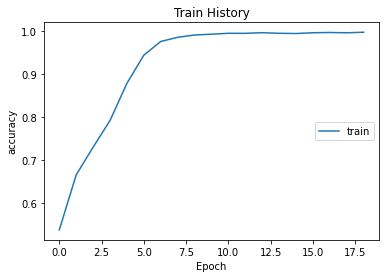

In [22]:
# if re-fit model, save a new training history plot & model itself
if not LOAD_MODEL:
    save_train_history(train_history, 'accuracy', 'accuracy')

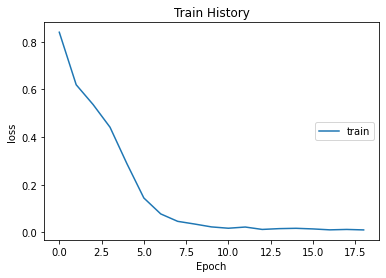

In [23]:
if not LOAD_MODEL:
    save_train_history(train_history, 'loss', 'loss')

In [24]:
if not LOAD_MODEL:
    model.save(PATH_FILE + 'my_cnn')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/機器深度學習導論/hw4/my_cnn/assets


In [25]:
# load model from saved no matter what
reconstructed_model = load_model(PATH_FILE + 'my_cnn')

##### Evaluation on training

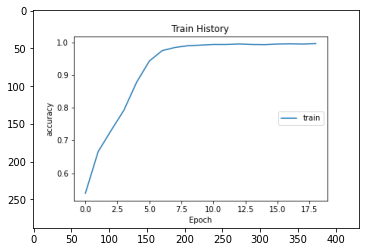

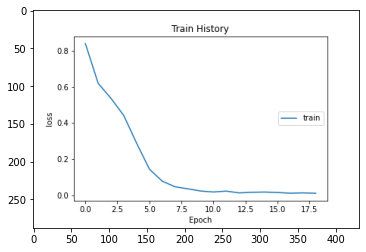

In [26]:
show_train_history('accuracy')
show_train_history('loss')

In [27]:
#顯示損失率與正確率
scores = reconstructed_model.evaluate(train_datasets)
print(f'on training data: loss = {scores[0]}, acc = {scores[1]}')

262/262 [==============================] - 68s 259ms/step - loss: 0.0031 - accuracy: 0.9994
on training data: loss = 0.0031331421341747046, acc = 0.9994029998779297


##### Evaluation on testing

In [28]:
scores = reconstructed_model.evaluate(test_datasets)
print(f'on test data: loss = {scores[0]}, acc = {scores[1]}')

129/129 [==============================] - 35s 268ms/step - loss: 1.9329 - accuracy: 0.7261
on test data: loss = 1.9329129457473755, acc = 0.7260606288909912


#### CNN model 2 - keras build-in

https://keras.io/api/applications/resnet/#resnet50v2-function

https://keras.io/api/applications/#usage-examples-for-image-classification-models

In [29]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.optimizers import SGD

In [30]:
# initialize the state to load or not to load the saved model
LOAD_MODEL = True

In [31]:
model = Sequential()
model.add(ResNet50V2(weights = 'imagenet', include_top = False, input_shape = (256,256,3)))
model.add(Flatten())
model.add(Dense(units = 300, activation = 'relu'))
model.add(Dense(units = 300, activation = 'relu'))
model.add(Dense(units = 2, activation = 'softmax'))
model.summary()

94683136/94668760 [==============================] - 3s 0us/step
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 8, 8, 2048)        23564800  
                                                                 
 flatten_1 (Flatten)         (None, 131072)            0         
                                                                 
 dense_2 (Dense)             (None, 300)               39321900  
                                                                 
 dense_3 (Dense)             (None, 300)               90300     
                                                                 
 dense_4 (Dense)             (None, 2)                 602       
                                                                 
Total params: 62,977,602
Trainable params: 62,932,162
Non-trainable params: 45,440
______________________________________

In [32]:
model.compile(loss="categorical_crossentropy", 
              optimizer=SGD(learning_rate=0.001), 
              metrics=['accuracy'])

In [33]:
# change load model state to False if re-fit a new model
LOAD_MODEL = False

for layer in model.layers:
    layer.trainable = True

ResNet50V2_history1 = model.fit(train_datasets, 
                                epochs=10, 
                                callbacks=[early], 
                                use_multiprocessing=True, 
                                workers=16, 
                                verbose=1)

Epoch 1/10
262/262 [==============================] - 415s 2s/step - loss: 0.1236 - accuracy: 0.9501
Epoch 2/10
262/262 [==============================] - 400s 2s/step - loss: 0.0223 - accuracy: 0.9942
Epoch 3/10
262/262 [==============================] - 400s 2s/step - loss: 0.0103 - accuracy: 0.9981
Epoch 4/10
262/262 [==============================] - 399s 2s/step - loss: 0.0067 - accuracy: 0.9992
Epoch 5/10
262/262 [==============================] - 398s 2s/step - loss: 0.0053 - accuracy: 0.9993
Epoch 6/10
262/262 [==============================] - 400s 2s/step - loss: 0.0041 - accuracy: 0.9995
Epoch 7/10
262/262 [==============================] - 404s 2s/step - loss: 0.0026 - accuracy: 0.9998
Epoch 8/10
262/262 [==============================] - 403s 2s/step - loss: 0.0030 - accuracy: 0.9996
Epoch 9/10
262/262 [==============================] - 399s 2s/step - loss: 0.0024 - accuracy: 0.9998
Epoch 10/10
262/262 [==============================] - 404s 2s/step - loss: 0.0017 - accura

In [34]:
# Freeze core ResNet50V2 layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[-4:]:
    layer.trainable = True

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer=SGD(learning_rate=0.001), 
              metrics=['accuracy'])


ResNet50V2_history2 = model.fit(train_datasets, 
                                epochs=10, 
                                callbacks=[early], 
                                use_multiprocessing=True, 
                                workers=16, 
                                verbose=1)

Epoch 1/10
262/262 [==============================] - 133s 471ms/step - loss: 5.2735e-04 - accuracy: 0.9999
Epoch 2/10
262/262 [==============================] - 129s 471ms/step - loss: 4.8085e-04 - accuracy: 1.0000
Epoch 3/10
262/262 [==============================] - 128s 471ms/step - loss: 4.4957e-04 - accuracy: 1.0000
Epoch 4/10
262/262 [==============================] - 129s 474ms/step - loss: 4.2301e-04 - accuracy: 0.9999
Epoch 5/10
262/262 [==============================] - 128s 468ms/step - loss: 3.9934e-04 - accuracy: 1.0000
Epoch 6/10
262/262 [==============================] - 128s 467ms/step - loss: 3.8039e-04 - accuracy: 1.0000
Epoch 7/10
262/262 [==============================] - 127s 466ms/step - loss: 3.6304e-04 - accuracy: 1.0000
Epoch 8/10
262/262 [==============================] - 127s 466ms/step - loss: 3.4695e-04 - accuracy: 1.0000
Epoch 9/10
262/262 [==============================] - 126s 465ms/step - loss: 3.3233e-04 - accuracy: 1.0000
Epoch 10/10
262/262 [=======

##### save and load model & model history

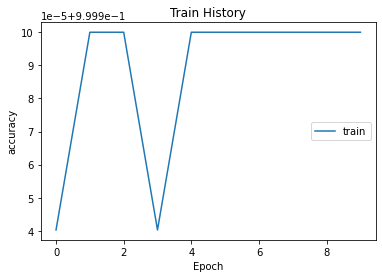

In [36]:
# if re-fit model, save a new training history plot & model itself
if not LOAD_MODEL:
    save_train_history(ResNet50V2_history2, 'accuracy', 'accuracy_resnet')

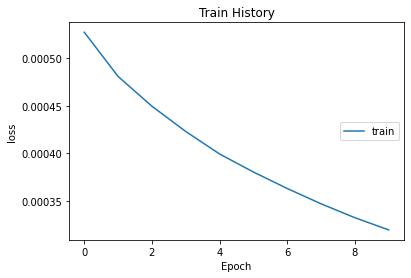

In [37]:
if not LOAD_MODEL:
    save_train_history(ResNet50V2_history2, 'loss', 'loss_resnet')

In [38]:
if not LOAD_MODEL:
    model.save(PATH_FILE + 'my_resnet')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/機器深度學習導論/hw4/my_resnet/assets


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)
/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [39]:
# load model from saved no matter what
reconstructed_model = load_model(PATH_FILE + 'my_resnet')

##### Evaluation on training

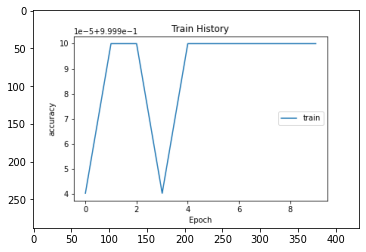

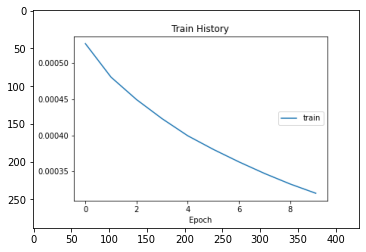

In [40]:
show_train_history('accuracy_resnet')
show_train_history('loss_resnet')

In [41]:
#顯示損失率與正確率
scores = reconstructed_model.evaluate(train_datasets)
print(f'on training data: loss = {scores[0]}, acc = {scores[1]}')

262/262 [==============================] - 120s 452ms/step - loss: 3.0084e-04 - accuracy: 1.0000
on training data: loss = 0.0003008435887750238, acc = 1.0


##### Evaluation on testing

In [42]:
scores = reconstructed_model.evaluate(test_datasets)
print(f'on test data: loss = {scores[0]}, acc = {scores[1]}')

129/129 [==============================] - 62s 475ms/step - loss: 0.0726 - accuracy: 0.9776
on test data: loss = 0.07264333218336105, acc = 0.9775757789611816


## 加分題1 : 實作卷積層與池化層(2維圖片/矩陣處理)
  1. 請將所有有含問號`?`的函式補齊，使程式能夠正常運作
      
      > `feature_map`、`conv2d`、`maxpooling2d`
  2. 
      > 請將測試圖丟進去`conv2d`、`maxpooling2d`中，並顯示結果

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import math
import cv2

In [6]:
img = cv2.imread(PATH_FILE + "cat_meme.png", cv2.IMREAD_GRAYSCALE)

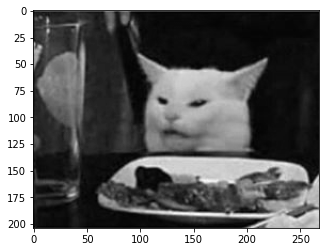

In [7]:
plt.imshow(img, cmap=plt.cm.gray)
plt.show()

In [8]:
print(img.shape)

(204, 268)


### Part 1

 請將所有有含問號?的函式補齊，使程式能夠正常運作

 參考資料：
 1. 「書籍」動手學深度學習
    - 第6章，卷積神經網路，6-2圖像卷積
 2. 「書籍」深度學習入門 - 基于Python的理论与实现
    - 第7章，卷積神經網路
 3. 「網路文章」https://cs231n.github.io/convolutional-networks/#conv

In [9]:
#計算feature_map size
def feature_map(w, h, p, ks, s):
    new_w = int((w + 2*p - ks) / s + 1) #計算新的width
    new_h = int((h + 2*p - ks) / s + 1) #計算新的height
    return new_w, new_h

In [18]:
#卷積層
#stride = 1
def conv2d(pic_array, conv_filter):
    result = []  #儲存最後輸出的結果
    stride = 1
    ##
    #計算卷積
    h, w = conv_filter.shape
    Y = np.zeros((pic_array.shape[0] - h + 1, pic_array.shape[1] - w + 1))
    for i in range(Y.shape[0]):
        for j in range(Y.shape[1]):
            #原先的圖因為輸出跟助教的不一樣，有在群組與組員討論問題所在，
            #其中一位組員有向助教詢問得知是因為值是負的所以才會導致圖片顏色與助教不一樣
            #所以之後就有加上了絕對值
            Y[i, j] = abs((pic_array[i:i + h, j:j + w] * conv_filter).sum())
    ##
    new_w, new_h = feature_map(pic_array.shape[0], pic_array.shape[1], 0, conv_filter.shape[0], stride)

    #將陣列轉回2維
    #result = np.array(result).reshape(new_w, new_h)
    #result = result.astype('uint8')
    return Y #result

In [49]:
#池化層
#pooling filter 一律為正方形
#
def maxpooling2d(pic_array, pooling_filter_width):
    result = []  #儲存最後輸出的結果
    stride = pooling_filter_width #將stride = pooling size
    ##
    #計算池化  
    ??
    ##
    new_w, new_h = feature_map(pic_array.shape[0], pic_array.shape[1], 0, pooling_filter_width, stride)
    
    #將陣列轉回2維
    result = np.array(result).reshape(new_w,new_h)
    result = result.astype('uint8')
    return result

### Part 2

請將測試圖丟進去`conv2d`、`maxpooling2d`中，並顯示圖片與shape

1.卷積結果示意圖
![avatar][base64conv2d]

2.max pooling結果示意圖
![avatar][base64maxpooling2d]

[base64maxpooling2d]: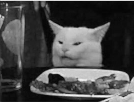
[base64conv2d]: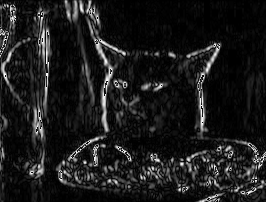

#### Conv2d

In [19]:
#請勿修改此kernel
conv_filter = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])

In [20]:
con = conv2d(img, conv_filter)

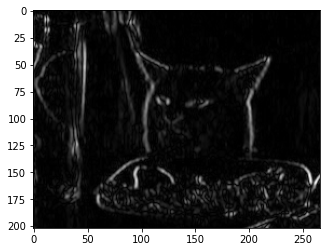

In [21]:
plt.imshow(con, cmap=plt.cm.gray)
plt.show()

In [22]:
print(con.shape)

(202, 266)


#### MaxPooling2d

In [54]:
max_pool = maxpooling2d(img, 2)

Object `` not found.


ValueError: ignored

In [ ]:
plt.imshow(max_pool, cmap=plt.cm.gray)
plt.show()

In [ ]:
print(max_pool.shape)

### 加分題 2 - 心得

請寫下完成本作業中所遇到的困難或是感想(字數不限)  
但請不要過於敷衍

多虧了助教先幫大家整理的詳細筆記，所以才能在參考助教程式時就能得到很多的資訊。另外，發現書籍是真的很值得投資的項目，實作上幾乎所有遇到的問題或不了解的地方都能在書上找到解答，而不是一昧的在網路上大海撈針，甚至還需要懷疑內容的可信度。

在實作`conv2d`的部分，因為輸出的圖片與助教的不一樣，所以有在群組與組員們討論。其中一位組員有提到助教說是因為算出來的值是負的關係，所以之後便把值都取絕對值，才得到與助教一樣的圖。助教們和組員都是神人，謝謝carry！